In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Import the relevant models - random forest and others for comparison:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier




In [5]:
ww = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-white.csv', sep=';')

ww['quality_label'] = ww['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# Transforming these labels into categrical data type instead of string
ww['quality_label'] = pd.Categorical(ww['quality_label'],
categories=['low', 'medium', 'high'])

# Encode quality labels as numbers
le = LabelEncoder()
ww['encoded_quality_label'] = le.fit_transform(ww['quality_label'])  

# Swap 0 for 3 to make the order make sense from low to high
ww['encoded_quality_label'].replace(0,3,inplace=True)

# Drop quality 1-10 and low-high columns
ww.drop(['quality_label'], axis=1, inplace=True)
ww.drop(['quality'], axis=1, inplace=True)

# Create column vector for encoded quality label
y_ww_quality = ww.encoded_quality_label


In [6]:
# Select ALL features
ww_select = ww.drop(['encoded_quality_label'], axis=1)
# Split data
ww_features_train, ww_features_test, ww_quality_train, ww_quality_test = train_test_split(ww_select,y_ww_quality,test_size=0.2, random_state=8)
# Scale features
scaler = RobustScaler()
ww_features_train_scaled = scaler.fit_transform(ww_features_train)
ww_features_train_scaled_df = pd.DataFrame(ww_features_train_scaled, columns=ww_features_train.columns)
ww_features_test_scaled = scaler.transform(ww_features_test)

# Randomized hyperparameter search

In [21]:
def randomized_searchCV(model, X_train, y_train):


    # Define hyperparameter search space
    param_dist = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [40, 50, 60],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True],
    'criterion': ['entropy']
    }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=5)

    # Fit the object to the data
    random_search.fit(X_train, y_train)

    # Get best hyperparameter combination
    best_params = random_search.best_params_

    return best_params

# Define the model
random_forest = RandomForestClassifier()

# Call the function with our training data
best_params = randomized_searchCV(random_forest, ww_features_train_scaled, ww_quality_train)
display(best_params)

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 60,
 'criterion': 'entropy',
 'bootstrap': True}

In [8]:
new_robust = {'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 60,
 'criterion': 'entropy',
 'bootstrap': True}

Use the RandomSearchCV results to narrow the parameter grid in GridSearchCV, otherwise it will take too long to run through all the combinations.
Example, n_estimators came out at 200, so we can leave out 10, 50, 100 and just try 200 and upwards; 'entropy' beat 'gini' so leave out gini. Keep bootstrap as 'True'. 

In [37]:
display(best_params_forest_robust_randomsearch)

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

In [4]:
robust_params = {'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}

In [24]:
def single_model_accuracy(X_train, y_train, X_test, y_test, clf):
    # Fit the model and make predictions
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    # Calculate metrics
    train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
    test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
    precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
    recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
    f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
    cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, test_predictions)

    # Create a mask for off-diagonal cells
    mask = np.ones_like(cm, dtype=bool)
    np.fill_diagonal(mask, 0)

    # Color palettes
    summer_palette = sns.color_palette(palette='summer_r')
    incorrect_cmap = sns.color_palette("flare", as_cmap=True)

    # Plot the heatmap
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, 
                xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, vmax=cm.max(),
                xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title("Model Accuracy")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.tight_layout()
    plt.show()

    # Prepare the metrics dataframe for display
    metrics_df = pd.DataFrame({
        'Classifier': ["Model"],
        'Test Accuracy': [test_accuracy],
        'Train Accuracy': [train_accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        "Cohen's Kappa": [cohen_kappa]
    })

    display(metrics_df)




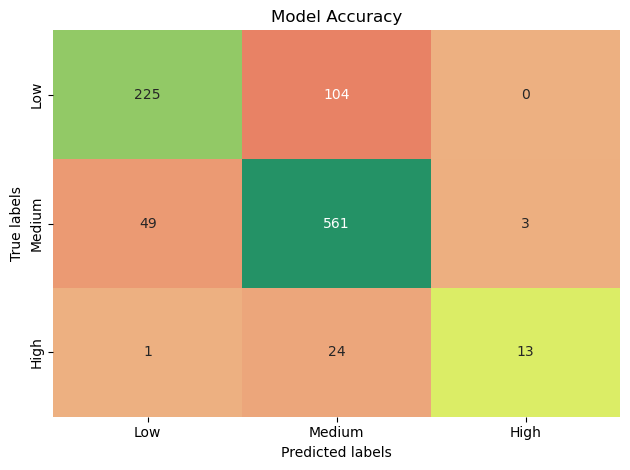

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Model,81.53,100.0,81.55,81.53,80.78,0.6


In [25]:
# Call the function with the desired classifier
clf = RandomForestClassifier(**new_robust)
single_model_accuracy(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test, clf)

# GridSearchCV

In [ ]:
# Adapt random search here

def grid_searchCV(model, X_train, y_train):


    # Define hyperparameter search space
    param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

    # Create RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)

    # Fit the object to the data
    grid_search.fit(X_train, y_train)

    # Get best hyperparameter combination
    best_params = grid_search.best_params_

    return best_params

# Define the model
random_forest = RandomForestClassifier()

# Call the function with out training data
best_params_forst_robust_gridsearch = grid_searchCV(random_forest, ww_features_train_scaled, ww_quality_train)

In [34]:
def model_accuracy_comparison(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Random Forest Tuned Robust', RandomForestClassifier(**best_params)),
        ('Random Forest Tuned', RandomForestClassifier(n_estimators = 50, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=20, criterion = 'entropy', bootstrap=True, random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        
    ]
    # Create a figure to accommodate the heatmaps for each model
    fig, axs = plt.subplots(1, len(classifiers), figsize=(16, 3))
    
    metrics_df = pd.DataFrame(columns=['Classifier', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

    for idx, (name, clf) in enumerate(classifiers):
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        test_predictions = clf.predict(X_test)
        
        # Calculate metrics
        train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
        test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
        precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
        recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
        f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
        cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
        
        # Create confusion matrix and heatmap of it
        cm = confusion_matrix(y_test, test_predictions)

        # Create a mask for off-diagonal cells
        mask = np.ones_like(cm, dtype=bool)
        np.fill_diagonal(mask, 0)

        summer_palette = sns.color_palette(palette='summer_r')
        incorrect_cmap = sns.color_palette("flare", as_cmap=True)

        
        # Plot the heatmap with the mask
        sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, ax=axs[idx])
        sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, ax=axs[idx], vmax=cm.max())
        axs[idx].set_title(name)
        axs[idx].set_xlabel('Predicted labels')
        axs[idx].set_ylabel('True labels')

        metrics_row = {
            'Classifier': name,
            'Test Accuracy': test_accuracy,
            'Train Accuracy': train_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            "Cohen's Kappa": cohen_kappa
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])]).reset_index(drop=True)
        metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
    
    # Display the heatmap visualization
    plt.tight_layout()
    plt.show()

    display(metrics_df)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


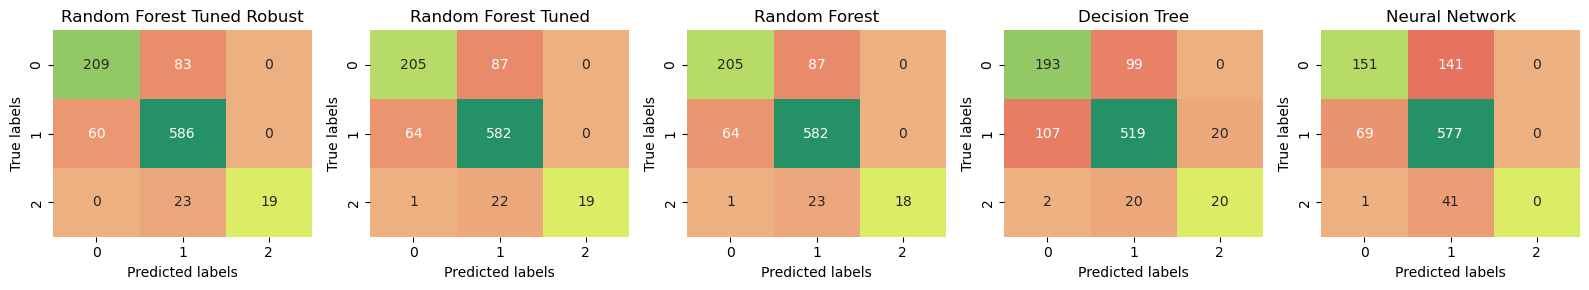

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest Tuned Robust,83.06,100.00,83.26,83.06,82.61,0.63
1,Random Forest Tuned,82.24,100.00,82.43,82.24,81.80,0.61
2,Random Forest,82.14,100.00,82.35,82.14,81.65,0.60
3,Decision Tree,74.69,100.00,74.81,74.69,74.74,0.47
4,Neural Network,74.29,73.97,70.47,74.29,71.68,0.39


In [35]:
model_accuracy_comparison(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)

# K-folds cross referencing

In [9]:
def model_cross_val(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Random Forest Robust', RandomForestClassifier(**new_robust)),
        ('Random Forest Tuned', RandomForestClassifier(n_estimators = 50, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=20, criterion = 'entropy', bootstrap=True, random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Support Vector Classification', SVC()),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        
    ]

    cross_val_metrics_df = pd.DataFrame(columns=['Classifier', 'Mean Accuracy', 'Standard Deviation'])

    
    for name, clf in classifiers:

        # Perform 5-fold cross-validation
        scores = cross_val_score(clf, X_train, y_train, cv=5)

        # Calculate the mean and standard deviation of the scores
        mean_score = scores.mean().round(3)
        std_dev = scores.std().round(3)

        cross_val_metrics_row = {
            'Classifier': name,
            'Mean Accuracy': mean_score,
            'Standard Deviation': std_dev
        }

        cross_val_metrics_df = pd.concat([cross_val_metrics_df, pd.DataFrame([cross_val_metrics_row])]).reset_index(drop=True)
        cross_val_metrics_df = cross_val_metrics_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
    
    return cross_val_metrics_df

In [10]:
models_cross_val_df = model_cross_val(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)
display(models_cross_val_df)

,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest Robust,0.800,0.015
1,Random Forest Tuned,0.799,0.012
2,Random Forest,0.797,0.012
3,Support Vector Classification,0.748,0.012
4,Neural Network,0.733,0.012
5,Decision Tree,0.716,0.018


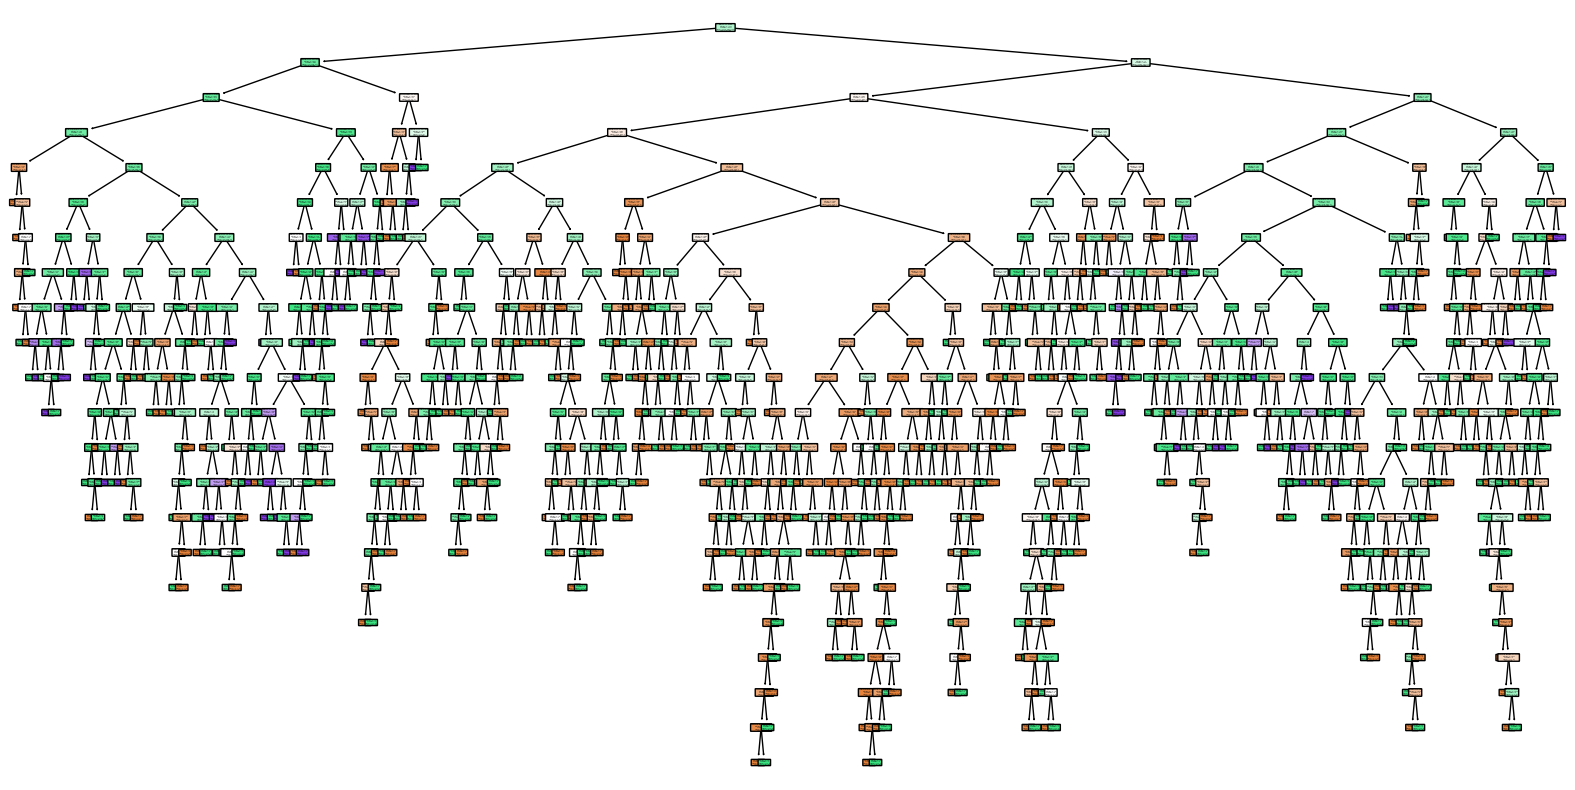

In [11]:
robust_params = {'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': True}
rf = RandomForestClassifier(**robust_params)
rf.fit(ww_features_train_scaled, ww_quality_train)

from sklearn.tree import plot_tree

# Select one of the decision trees (e.g., the first one)
single_tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, feature_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'], class_names=['Low', 'Medium', 'High'], filled=True, rounded=True)
plt.show()
